# PY OOP

In [121]:
import pandas as pd
from scipy.integrate import odeint
import numpy as np
import pylab as pl
import matplotlib.pyplot as plt
import random
from statistics import mean 
import itertools
import ga 

path_file="https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-andamento-nazionale/dpc-covid19-ita-andamento-nazionale.csv"
dataset=pd.read_csv(path_file,parse_dates=['data'])

# guariti,infetti,sani, morti 
dataset['asintomatici']= dataset['totale_casi'] * 0.44 
dataset['immuni'] = dataset['dimessi_guariti'] * 0.05  #verificare proporzione
data=dataset[['totale_positivi','dimessi_guariti','deceduti','asintomatici','immuni']]


In [73]:
class Parameters:
    def __init__(self):
        pass
    def initializeParameters(self,minimo,massimo,n=9):
        self.minimo=minimo
        self.massimo=massimo
        return [random.uniform(self.minimo,self.massimo) for i in range(0,n)]
    


    
    
        

In [176]:
class A(Parameters):
    def __init__(self):
        self.param = Parameters().initializeParameters(0,1) 
        self.k1=self.param[0]
        self.k2=self.param[1]
        self.k3=self.param[2]
        self.k4=self.param[3]
        self.k5=self.param[4]
        self.k6=self.param[5]
        self.k7=self.param[6]
        self.k8=self.param[7]
        self.k9=self.param[8]
    
    @staticmethod
    def deriv(y,t,k1,k2,k3,k4,k5,k6,k7,k8,k9):  
        '''set di equazioni differenziali'''
        Sani,Infetti,Asintomatici,Morti,Guariti,Immuni = y 
        dSanidt =  -k1*Sani*Infetti -k2*Sani*Infetti-k3*Sani*Asintomatici- k4*Sani*Asintomatici
        dInfettidt = k1*Sani*Infetti+k4*Sani-k6*Infetti-k7*Infetti
        dAsintomaticidt =k2*Sani*Infetti+k3*Sani*Asintomatici-k5*Asintomatici
        dMortidt=k6*Infetti
        dGuaritidt = k5*Asintomatici+k7*Infetti-k8*Guariti-k9*Guariti
        dImmunidt = k9*Guariti
        return dSanidt,dInfettidt,dAsintomaticidt,dMortidt,dGuaritidt,dImmunidt  

    def perturbazione(self,ls):
        self.ls=ls
        sup = 0.2
        for i in range(len(self.ls)):
            if self.ls[i] < 0.5:
                self.ls[i]=random.uniform(self.ls[i],self.ls[i]+sup)
            else:
                self.ls[i]=random.uniform(0,self.ls[i]-sup)
        return(self.ls)

    def diffusione(self):
        orizzonte_temporale_in_gg=63
        Sani = 6036000
        Infetti=221
        Guariti=1
        Morti= 7
        Immuni = 8
        Asintomatici = 10
        y0 =  [Sani,Infetti,Morti,Guariti,Immuni,Asintomatici]
        t = np.linspace(0,orizzonte_temporale_in_gg,orizzonte_temporale_in_gg)
        ret = odeint(A.deriv, y0, t,args=(self.k1,self.k2,self.k3,self.k4,self.k5,self.k6,self.k7,self.k8,self.k9))
        return(ret)

    def fitness(self,previsti):
        self.previsti=previsti
        df=pd.DataFrame(self.previsti,columns=['sani','totale_positivi','dimessi_guariti','deceduti','asintomatici','immuni'])
        df=df.drop(columns=['sani'])
        dataframe=((df-data)**2)
        lista=dataframe.values.tolist()
        merged = list(itertools.chain.from_iterable(lista))
        media=mean(merged)
        return media 

    def localsearch(self,massimovaloreiniziale,iterazioni):
        self.massimovaloreiniziale=massimovaloreiniziale
        self.iterazioni=iterazioni
        iniziale = self.param
        k=[iniziale[0],iniziale[1],iniziale[2],iniziale[3],iniziale[4],iniziale[5],iniziale[6],iniziale[7],iniziale[8]]
        k1,k2,k3,k4,k5,k6,k7,k8,k9 =iniziale[0],iniziale[1],iniziale[2],iniziale[3],iniziale[4],iniziale[5],iniziale[6],iniziale[7],iniziale[8]
        errore=100000000000000000000000000000000000000
        val='1'
        for c in range(self.iterazioni):
            valori=self.diffusione()
            stimaerrore=self.fitness(valori)
            if stimaerrore<errore:
                errore=stimaerrore
                val=valori 
                k[0],k[1],k[2],k[3],k[4],k[5],k[6],k[7],k[8] =iniziale[0],iniziale[1],iniziale[2],iniziale[3],iniziale[4],iniziale[5],iniziale[6],iniziale[7],iniziale[8]
            iniziale = self.param
            k1,k2,k3,k4,k5,k6,k7,k8,k9 =iniziale[0],iniziale[1],iniziale[2],iniziale[3],iniziale[4],iniziale[5],iniziale[6],iniziale[7],iniziale[8]
        return(k,val,errore)
    
    def ils(self,iterazioni,max_iterazioni,massimovaloreiniziale):
        self.iterazioni=iterazioni
        self.max_iterazioni=max_iterazioni
        self.massimovaloreiniziale=massimovaloreiniziale
        iniziale = self.param
        loc_search = A().localsearch(self.massimovaloreiniziale,self.iterazioni)
        k=loc_search[0]
        best_val = loc_search[1]
        best_errore = loc_search[2]
        #iter_errore = [best_errore]
        #iter_best_errore = [best_errore]
        for c in range(max_iterazioni):
            val=best_val
            nuova_iniziale = A().perturbazione(k)
            loc_search = A().localsearch(massimovaloreiniziale,iterazioni)
            val = loc_search[1]
            if loc_search[2] < best_errore: # Se nuovo errore minore best si aggiorna il best
                best_errore = loc_search[2]
                best_val= loc_search[1]
                k=loc_search[0]
        # elif loc_search[0] == best_pers and loc_search[1] < best_num: # se uguale si tiene come best il numero più piccolo
                # best_num =loc_search[1]
            #iter_pers.append(loc_search[0])
        # iter_best_pers.append(best_pers)
    # results = {"errore":iter_pers, "persistenza_migliore":iter_best_pers, "numero_migliore":best_num,"ripetizioni":conta(best_num)}
        return(k,best_val,best_errore)  

    def grafico(self):
        ret=A().ils(10,10,1)
        ret=ret[1]
        fig = plt.figure(facecolor='w')
        ax = fig.add_subplot(111)
        t = np.linspace(0,61,63)
        ax.plot(t, ret[:,1], 'r', alpha=0.7 ,lw=2, label='Infetti')
        ax.plot(t, ret[:,2], 'g', alpha=0.7 ,lw=2, label='Deceduti')
        ax.plot(t, ret[:,3], 'k', alpha=0.7, lw=2, label='Guariti')
        ax.set_xlabel('tempo (in giorni)')
        ax.set_ylabel('Persone (x1000)')
        ax.set_ylim(0,700000)
        legend = ax.legend()
        for spine in ('top', 'right', 'bottom', 'left'):
            ax.spines[spine].set_visible(False)
        plt.show()  


    

    

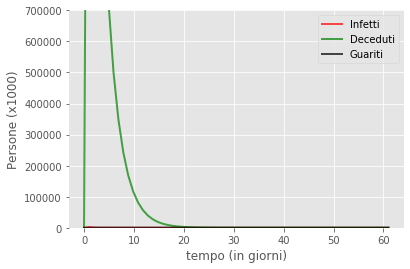

In [177]:
a=A()

a.grafico()


In [ ]:
for alpha in np.linspace(0.1,1,10):
    grafico(alpha,prova[1])
